In [77]:
# Created November 29, 2021
# Updated January 15, 2021
import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
if True:
    mpl.rcParams['lines.linewidth'] = 0.75
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.05
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['figure.facecolor'] = (1,1,1,1) #white
    mpl.rcParams['figure.edgecolor'] = (1,1,1,1) #white
    mpl.rcParams['axes.titlesize'] = 10
    mpl.rcParams['legend.fontsize'] = 6
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()

In [78]:
import methods.filter_lineages as fl
def muller_plot(ax, times, freqs, colors):
    """ freqs has dimensions of (time, bc freq).
     times and freqs.shape[0] should have same dimension. """
    cum_freqs = np.cumsum(freqs, axis=1)

    ax.fill_between(times, np.zeros(len(times)), cum_freqs[:, 0], color=colors[0])

    for i in range(freqs.shape[1]-2):
        ax.fill_between(times, cum_freqs[:, i], cum_freqs[:, i+1], color=colors[i])
    ax.fill_between(times, cum_freqs[:, freqs.shape[1]-2], cum_freqs[:, freqs.shape[1]-1], color='lightgrey')

# def make_muller_freqs(bac, mouse, cutoff=1e-2):
#     mouse_freqs = freq_dict[bac][bc][[ MX[(mouse, day)] for day in days]]
#     max_freqs = np.max(mouse_freqs, axis=0)
#     big_indices = np.where(max_freqs >= cutoff)[0]
#
#     day0_freqs = freq_dict[bac][bc][-1][big_indices]
#     day0_freqs = list(day0_freqs) + [1-np.sum(day0_freqs)]
#
#     freqs = [day0_freqs]
#     for day in days:
#         m_freqs = freq_dict[bac][bc][MX[(mouse, day)]]
#         big_barcode_freqs = m_freqs[big_indices]
#         coarse_grained_freqs = list(big_barcode_freqs) + [1-np.sum(big_barcode_freqs)]
#         freqs.append( coarse_grained_freqs )
#
#     freqs = np.array(freqs)
#
#     day16_sorted = np.argsort( freqs[-1, :-1] )[::-1]
#     freqs[:, :-1] = freqs[:, :-1][:, day16_sorted]
#     return freqs

def make_muller_freqs_multiple_mice(bac, mice, cutoff=1e-2):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    big_barcodes = set()

    for mouse in mice:
        mouse_reads = read_array[ [row_ids[(mouse, day)] for day in days] ]
        mouse_freqs = np.einsum('ij, i->ij', mouse_reads, mouse_reads.sum(axis=1)**-1.)

        max_freqs = np.max(mouse_freqs, axis=0)
        big_indices = np.where(max_freqs >= cutoff)[0]
        big_barcodes.update(big_indices)

    big_indices = list(big_barcodes)

    day0_reads = read_array[0]
    day0_freqs = (day0_reads / day0_reads.sum())[big_indices]
    day0_freqs = list(day0_freqs) + [1-np.sum(day0_freqs)]

    freqs = [[day0_freqs] for mouse in mice]
    for day in days:
        for m, mouse in enumerate(mice):
            mouse_reads = read_array[ row_ids[(mouse, day)] ]
            mouse_freqs = mouse_reads / mouse_reads.sum()
            big_barcode_freqs = mouse_freqs[big_indices]

            coarse_grained_freqs = list(big_barcode_freqs) + [1-np.sum(big_barcode_freqs)]
            freqs[m].append( coarse_grained_freqs )
    freqs = np.array(freqs)

    # sort on day 16 freqs
    day16_sorted = np.argsort( np.mean(freqs[:, -1][:, :-1], axis=0) )[::-1]
    freqs[:, :, :-1] = freqs[:, :, :-1][:, :, day16_sorted]
    return freqs, big_indices

def find_biggest_indices(mice, num_lineages=10):
    big_barcode_indices = {bac:{} for bac in bacteria}
    for bac in bacteria:
        row_ids = fl.bac_row_ids[bac]
        notWu = fl.bac_nonwu_indices[bac]
        read_array = fl.bac_read_arrays[bac][:, notWu]
        
        for mouse in mice:
            mouse_reads = read_array[ [row_ids[(mouse, day)] for day in days] ]
            mouse_freqs = np.einsum('ij, i->ij', mouse_reads, mouse_reads.sum(axis=1)**-1.)
    
            indices = np.argsort(mouse_freqs[-1])[-num_lineages:]
            
            big_barcode_indices[bac][mouse] = list(indices)
    return big_barcode_indices

def find_biggest_indices_v2(num_lineages=10):
    big_barcode_indices = {bac:{diet:[] for diet in ['HF', 'LF', 'HLH', 'LHL']} for bac in bacteria}
    for bac in bacteria:
        for diet in ['HF', 'LF', 'HLH', 'LHL']:
            mice = diet_mice_map[diet]
            row_ids = fl.bac_row_ids[bac]
            notWu = fl.bac_nonwu_indices[bac]
            read_array = fl.bac_read_arrays[bac][:, notWu]

            mice_reads = read_array[ [row_ids[(mouse, 16)] for mouse in mice] ].sum(axis=0)
            mice_freqs = mice_reads / mice_reads.sum()
            sorted_indices = np.argsort(mice_freqs)[::-1]

            mouse_reads = read_array[ [row_ids[(mouse, 16)] for mouse in mice] ]
            mouse_freqs = np.einsum('ij, i->ij', mouse_reads, mouse_reads.sum(axis=1)**-1.)

            topX = []
            for index in sorted_indices:
                mouse_bool =  ( (mouse_freqs[:, index] > 1e-3).sum() > 1 )
                if mouse_bool:
                    topX.append(index)
                if len(topX) == num_lineages:
                    break
            big_barcode_indices[bac][diet] = topX
            print(bac, diet, mice_freqs[topX] / 10**-3)
    return big_barcode_indices

def make_muller_freqs(bac, mouse, indices, cmap):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    big_indices = list(indices)

    day0_reads = read_array[0]
    day0_freqs = (day0_reads / day0_reads.sum())[big_indices]
    day0_freqs = list(day0_freqs) + [1-np.sum(day0_freqs)]

    freqs = [day0_freqs]
    for day in days:
        mouse_reads = read_array[ row_ids[(mouse, day)] ]
        mouse_freqs = mouse_reads / mouse_reads.sum()
        big_barcode_freqs = mouse_freqs[big_indices]

        coarse_grained_freqs = list(big_barcode_freqs) + [1-np.sum(big_barcode_freqs)]
        freqs.append( coarse_grained_freqs )

    freqs = np.array(freqs)
    # sort on day 16 freqs
    day16_sorted = np.argsort( freqs[-1][:-1] )[::-1]
    freqs[:, :-1] = freqs[:, :-1][:, day16_sorted]

    sorted_cmap = cmap[day16_sorted]
    return freqs, sorted_cmap

def transition_curve(ax, bac, mice, input_rep, day, target_read_range):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    input_array = fl.bac_input_arrays[bac][:, notWu]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    null_reads = input_array[input_rep]
    day0_reads = read_array[0] - null_reads
    day0_freqs = day0_reads / day0_reads.sum()

    ## null_distribution
    null_indices = (day0_freqs * null_reads.sum() > target_read_range[0]) * (day0_freqs * null_reads.sum() < target_read_range[1])
    read_density = np.bincount(null_reads[null_indices])
    read_density = read_density / read_density.sum()
    ax.fill_between(np.arange(read_density.shape[0]), read_density, color='lightgrey')

    for mouse in mice:
        mouse_reads = read_array[row_ids[(mouse, day)]]
        mouse_indices = (day0_freqs * mouse_reads.sum() > target_read_range[0]) * (day0_freqs * mouse_reads.sum() < target_read_range[1])
        print(mouse_indices.sum())
        read_density = np.bincount(mouse_reads[mouse_indices])
        read_density = read_density / read_density.sum()
        ax.plot(np.arange(read_density.shape[0]), read_density, color=DIET_COLORS[mouse2diet[mouse]])

In [79]:
biggest_indices2 = find_biggest_indices_v2(10)
with open('10biggest_indices_v2.pkl', 'wb') as f:
    pickle.dump(biggest_indices2, f)

BWH2 HF [25.65819097 20.88500784 14.43224666 13.71901537  8.03233661  7.54916322
  6.53721938  5.47786496  5.43149068  5.25117503]
BWH2 LF [30.51506548  9.7116657   6.6582942   6.46743368  5.93889686  5.18696196
  5.0250678   4.69850188  4.43780467  4.01402289]
BWH2 HLH [41.0929836  24.79142262 24.00318548 12.15342012 10.47247415 10.15761309
  9.95951451  8.50522512  6.94881375  6.80186654]
BWH2 LHL [50.01011376 17.48074373 12.67296395  9.98104607  9.97087881  8.99508867
  8.75455253  7.48899527  6.63200164  6.62772068]
Bovatus HF [55.31785471 45.50539209 44.68317628 36.66979401  9.69905355  7.30199806
  7.24271604  3.14194692  2.64707095  2.27849145]
Bovatus LF [44.82526506 28.493909   27.04072086 27.01398997 25.41985716 25.07114061
 23.92778773 23.35914889 20.05302436 12.71782634]
Bovatus HLH [138.51129077 106.16113744  46.98076387  46.61276833  44.92890995
  42.33063842  41.115138    24.37691664  24.02007248  21.90131029]
Bovatus LHL [29.44702538 26.69632065 26.20341574 25.31463998 

In [32]:
biggest10_indices = find_biggest_indices([1,2,3,5,6,7,8,9,10,11,12,13,15,16,18,19], num_lineages=10)
# biggest_indices = find_biggest_indices([1, 2, 3, 5, 11, 12, 13, 15], num_lineages=1000)
# with open('10biggest_indices.pkl', 'wb') as f:
#     pickle.dump(biggest10_indices, f)
#
# biggest5_indices = find_biggest_indices([1,2,3,5,6,7,8,9,10,11,12,13,15,16,18,19], num_lineages=5)
# # biggest_indices = find_biggest_indices([1, 2, 3, 5, 11, 12, 13, 15], num_lineages=1000)
# with open('5biggest_indices.pkl', 'wb') as f:
#     pickle.dump(biggest5_indices, f)

In [81]:
for bac in BACTERIA:
    for mouse in [8, 10, 16, 19]:
        id = fl.bac_row_ids[bac][(mouse, 4)]
        nonWu = fl.bac_nonwu_indices[bac]
        mouse_reads = fl.bac_read_arrays[bac][id, nonWu]
        mouse_freqs = mouse_reads / mouse_reads.sum()
        print(np.max(mouse_freqs)/10**-2)


0.09859391925289471
0.0966708455216604
0.21399873901818298
0.20572562849902196
0.3894335257958902
0.3951981814457666
0.14579789634463844
0.15368026443082874
0.22245234533808922
0.22550638263600853
0.210038188761593
0.25340497797847755
0.616179102725859
1.4398476855340923
0.161154314625691
0.20291639844384116


5727
5072
7231
6742
1586
1889
1112
1565
2122
2445
1304
1909
244
558
597
869


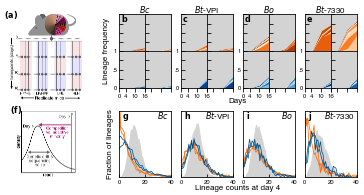

In [76]:
bac_lst = ['BWH2', 'BtVPI', 'Bovatus', 'Bt7330']
muller_mice = [[8, 10], [16, 19]]
transition_day = 4
expected_reads = [10, 15]
input_rep = 0

diet_cmaps = {'HF':'Oranges', 'LF':'Blues'}



fig = plt.figure(figsize=(6.5, 3))
outer = mpl.gridspec.GridSpec(nrows=3, ncols=len(bac_lst)+2, width_ratios=[2, 0.03, 1, 1, 1, 1],
                              height_ratios=[2,0.1,1.8], figure=fig)

### SCHEMATICS
if 'schematics':
    # experiment schematic
    lineage_schematic_ax = fig.add_subplot(outer[:2, 0])
    im = mpl.image.imread('lineage_schematic.png')
    lineage_schematic_ax.imshow(im)
    ax_methods.turn_off_ax(lineage_schematic_ax)
    lineage_schematic_ax.set_xticks([])
    lineage_schematic_ax.set_yticks([])
    lineage_schematic_ax.text(-0.07, 0.96, '$\\bf{(a)}$', fontsize=8, transform=lineage_schematic_ax.transAxes)

    # branching process picture
    bp_schematic_ax = fig.add_subplot(outer[2, 0])
    im = mpl.image.imread('bp_schematic.png')
    num_rows, num_cols = im.data.shape[:-1]
    bp_schematic_ax.imshow(im)#, extent=(-0.5, 1.5*num_cols, 1.3*num_rows, -2*num_rows))
    ax_methods.turn_off_ax(bp_schematic_ax)
    bp_schematic_ax.set_xticks([])
    bp_schematic_ax.set_yticks([])
    bp_schematic_ax.text(-0.09, 0.98, '$\\bf{(f)}$', fontsize=8, transform=bp_schematic_ax.transAxes)

if 'muller plots':
    muller_lineages = {}
    muller_group_ax = fig.add_subplot(outer[0, 2:])
    muller_group_ax.set_xlabel('Days', fontsize=8, labelpad=3)
    muller_group_ax.set_ylabel('Lineage frequency', labelpad=-1, fontsize=8)
    ax_methods.turn_off_ax(muller_group_ax)

    muller_ax_indices = {0:'$\\bf{b}$', 1:'$\\bf{c}$', 2:'$\\bf{d}$', 3:'$\\bf{e}$'}
    for b, bac in enumerate(bac_lst):
        muller_gs = mpl.gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0, b+2], hspace=0, wspace=0)

        muller_ax = fig.add_subplot(muller_gs[:])

        ax_methods.turn_off_ax(muller_ax)
        muller_axes = {}
        muller_ax.set_title(BAC_FORMAL_NAMES[bac], fontsize=8, pad=2)
        muller_ax.set_yticks([])

        for m, mice in enumerate(muller_mice):
            diet = mouse2diet[mice[0]]
            indices = rnd.permutation(list(set(np.ravel([biggest10_indices[bac][mouse] for mouse in mice]))))
            cmap = plt.cm.get_cmap( diet_cmaps[diet] ) # color by diet
            pooled_cmap = rnd.permutation( list(iter(cmap(np.linspace(0, 1, len(indices))))) )
            pooled_cmap = {index: pooled_cmap[i] for i, index in enumerate(indices)}

            for k, mouse in enumerate(mice):
                ax = fig.add_subplot(muller_gs[m, k])
                muller_axes[ (m, k) ] = ax

                indices = biggest10_indices[bac][mouse]
                cmap = np.array([pooled_cmap[index] for index in indices])


                muller_freqs, cmap = make_muller_freqs(bac, mouse, indices, cmap)
                print(max(muller_freqs[1]))
                muller_plot(ax, [0]+days, muller_freqs, cmap)

                if 'format muller plot':
                    ax.tick_params(axis='x', direction='out')
                    ax.set_xlim(0, 16)
                    ax.set_xticks([0, 4, 10, 16])
                    ax.set_ylim(0, 1)
                    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
                    ax.set_yticklabels( (ax.get_yticks() * 100).astype(int) )
                    if m == 1 and k == 0:
                        ax.set_xticklabels([0, 4, 10, 16])
                        ax.set_yticklabels(['0', '', '.5', '', '1'])
                    if k == 1 or m == 0:
                        ax.set_yticklabels([])
                        ax.set_xticklabels([])
                    if m == 0:
                        ax.set_xticks([])
                    if m == 0 and k == 0:
                        ax.text(0.05, 0.79, muller_ax_indices[b], fontsize=8, zorder=100, transform=ax.transAxes)
                        # ax.text(0.85, 0.82, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=7, horizontalalignment='left')
                    # if m==0 and k == 1:
                        # ax.text(0.95, 0.85, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=6, horizontalalignment='right')

if 'transition curves':
    transition_group_ax = fig.add_subplot(outer[2, 2:])
    transition_group_ax.set_xlabel('Lineage counts at day 4', fontsize=8, labelpad=0)
    transition_group_ax.set_ylabel('Fraction of lineages', fontsize=8, labelpad=-5)
    ax_methods.turn_off_ax(transition_group_ax)

    transition_ax_indices = {0:'$\\bf{g}$', 1:'$\\bf{h}$', 2:'$\\bf{i}$', 3:'$\\bf{j}$'}
    for b, bac in enumerate(bac_lst):
        transition_gs = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[2, b+2])
        ax = fig.add_subplot(transition_gs[0])
        transition_curve(ax, bac, np.ravel(muller_mice), input_rep, transition_day, expected_reads)

        if 'format transition curves':
            # ax.set_title(BAC_FORMAL_NAMES[bac], fontsize=8)
            ax.set_xlim(0, 40)
            ax.set_ylim(0, 0.12)
            # ax.set_yticks([0, 0.05, 0.1])
            ax.set_yticks([])
            ax.text(0.05, 0.88, transition_ax_indices[b], fontsize=8, transform=ax.transAxes)
            ax.text(0.96, 0.88, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=8, horizontalalignment='right')

            if b == 0:
                # ax.set_yticklabels([0, '.05', '.1'])
                pass
            else:
                # ax.set_yticklabels([])
                pass



fig.savefig(f'{biorxiv}/fig1_muller_and_transition_10biggest.pdf')


